### Activity 7.01 : Building DCGAN for MNIST FASHION

In [1]:
# Import the required library functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten,Activation
from tensorflow.keras.layers import LeakyReLU,BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D,Conv2DTranspose
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to generate real data samples
def realData(batch):
    # Get the MNIST data 
    (X_train, _), (_, _) = fashion_mnist.load_data()
    # Reshaping the input data to include channel
    X = X_train[:,:,:,np.newaxis]
    # normalising the data to be between 0 and 1
    X = (X.astype('float32') - 127.5)/127.5
    # Generating a batch of data
    imageBatch = X[np.random.randint(0, X.shape[0], size=batch)]
    return imageBatch
    

In [3]:
# Generating a set of  sample images 
fashionData = realData(25)

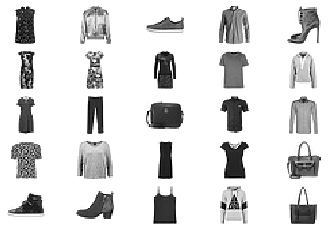

In [4]:
# Visualizing the plots
for j in range(5*5):
    pyplot.subplot(5,5,j+1)
    # turn off axis 
    pyplot.axis('off') 
    pyplot.imshow(fashionData[j,:,:,0],cmap='gray_r')

In [5]:
# Function to generate inputs for generator function
def fakeInputs(batch,infeats):
    # Generate random noise data with shape (batch,input features)
    x_fake = np.random.uniform(-1,1,size=[batch,infeats])
    return x_fake

In [6]:
# Function for the generator model
def genModel(infeats):
    # Defining the Generator model
    Genmodel = Sequential()
    Genmodel.add(Dense(512,input_dim=infeats))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # second layer of FC => RElu => BN layers
    Genmodel.add(Dense(7*7*64))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Upsample to 14 x 14
    Genmodel.add(Reshape((7,7,64)))
    Genmodel.add(Conv2DTranspose(32,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization(axis = -1))
    # Updample to 28 x 28
    Genmodel.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('tanh'))    
    return Genmodel



In [7]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel,batch,infeats):
    # first generate the inputs to the model
    genInputs = fakeInputs(batch,infeats)
    # use these inputs inside the generator model to generate fake distribution
    X_fake = Genmodel.predict(genInputs)   
    
    return X_fake

In [8]:
# Define the arguments like batch size and input feature
batch = 128
infeats = 100
Genmodel = genModel(infeats,)
Genmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0

In [9]:
# Generating a fake sample and printing the shape
fake = fakedataGenerator(Genmodel,batch,infeats)
fake.shape

(128, 28, 28, 1)

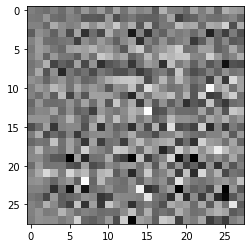

In [10]:
# Plotting the fake sample

plt.imshow(fake[1, :, :, 0], cmap='gray_r')

In [11]:
# Descriminator model as a function
def discModel():
    Discmodel = Sequential()
    Discmodel.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))    
    Discmodel.add(LeakyReLU(0.2))
    # second layer of convolutions
    Discmodel.add(Conv2D(64, kernel_size=(5,5), strides=(2, 2), padding='same'))   
    Discmodel.add(LeakyReLU(0.2))
    # Fully connected layers
    Discmodel.add(Flatten())
    Discmodel.add(Dense(512))
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dense(1, activation='sigmoid'))
    Discmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5),metrics=['accuracy'])   
    return Discmodel 

In [12]:
# Print the summary of the discriminator model
Discmodel = discModel()
Discmodel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)              

Next we develop the GAN model 

In [13]:
# Define the combined generator and discriminator model, for updating the generator
def ganModel(Genmodel,Discmodel):
    # First define that discriminator model cannot be trained
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # First adding the generator model
    Ganmodel.add(Genmodel)
    # Next adding the discriminator model without training the parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimise the Generator model
    Ganmodel.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.0002, beta_1=0.5))    
    return Ganmodel

In [14]:
# Initialise the gan model
gan_model = ganModel(Genmodel,Discmodel)
# Print summary of the GAN model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         1727233   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1658753   
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


In [16]:
# Defining the number of epochs
nEpochs = 5000

In [17]:
# Train the GAN network
for i in range(nEpochs):
    # Generate samples equal to the bath size from the real distribution
    x_real = realData(batch)
    # Generate fake samples using the fake data generator function
    x_fake = fakedataGenerator(Genmodel,batch,infeats)
    # Concatenating the real and fake data 
    X = np.concatenate([x_real,x_fake])
    # Creating the dependent variable and initializing them as '0'
    Y = np.zeros(batch * 2)
    # making the first set equivalent to batch with labels 1
    Y[:batch] = 1
    # train the  discriminator on the real samples
    discLoss = Discmodel.train_on_batch(X, Y)
    # Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch*2,infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch*2, 1))
    # Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 10 epochs
    if (i) % 50 == 0:
        # Printing the descriminator loss and accuracy
        x_real_test = realData(10)
        x_fake_test = fakedataGenerator(Genmodel,10,infeats)
        # Concatenating the real and fake data 
        X_test = np.concatenate([x_real_test,x_fake_test])
        # Creating the dependent variable and initializing them as '0'
        Y = np.zeros(20 * 2)
        Y[:10] = 1
        # Predicting probabilities
        preds = Discmodel.predict_proba(X_test)
        print('Discriminator probability:{D}'.format(D=np.mean(preds)))
        # Generate fake samples using the fake data generator function
        x_fake = fakedataGenerator(Genmodel,batch,infeats)
        # Saving the plots
        for j in range(5*5):
            pyplot.subplot(5,5,j+1)
            # turn off axis 
            pyplot.axis('off') 
            pyplot.imshow(x_fake[j,:,:,0],cmap='gray_r')
        filename = 'output/Activity7.01_GAN_MNIST_Fashion_Training_Plot%03d.png' % (i)
        pyplot.savefig(filename)
        pyplot.close()
            
        


Discriminator probability:0.5383890867233276
Discriminator probability:0.5012128353118896
Discriminator probability:0.5000524520874023
Discriminator probability:0.4997991919517517
Discriminator probability:0.5000231266021729
Discriminator probability:0.7880662679672241
Discriminator probability:0.34970206022262573
Discriminator probability:0.39579957723617554
Discriminator probability:0.5247521996498108
Discriminator probability:0.47924748063087463
Discriminator probability:0.6197860240936279
Discriminator probability:0.3751375079154968
Discriminator probability:0.4866889417171478
Discriminator probability:0.5481897592544556
Discriminator probability:0.44986605644226074
Discriminator probability:0.4804844260215759
Discriminator probability:0.4056417942047119
Discriminator probability:0.4771345257759094
Discriminator probability:0.509711503982544
Discriminator probability:0.6139271855354309
Discriminator probability:0.3394635319709778
Discriminator probability:0.48280876874923706
Discri

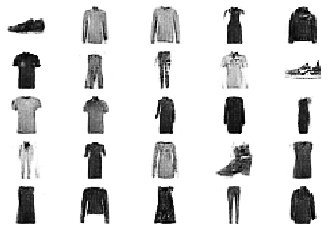

In [19]:
# Images generated after training
x_fake = fakedataGenerator(Genmodel,25,infeats)
# Saving the plots
for j in range(5*5):
    pyplot.subplot(5,5,j+1)
    # turn off axis 
    pyplot.axis('off')
    pyplot.imshow(x_fake[j,:,:,0],cmap='gray_r')